In [94]:
import numpy as np

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 8)

In [89]:
class ToyModel(nn.Module):
    def __init__(self, target, init='zero'):
        super(ToyModel, self).__init__()
        self.target = autograd.Variable(
            torch.Tensor(1), requires_grad=False
        )
        self.target[0] = target
        self.logit = autograd.Variable(
            torch.Tensor(1), requires_grad=True
        )
        if init == 'zero':
            self.logit.data.zero_()
        elif init == 'random':
            self.logit.data.normal_()
        else:
            raise ValueError()
        
    def forward(self, mode='hard_sample', temperature=1.):
        self.prob = torch.sigmoid(self.logit)
        if mode == 'expectation':
            return self.prob * (1 - self.target) ** 2 + (1 - self.prob) * self.target ** 2
        else:
            if mode == 'soft_sample':
                u = autograd.Variable(
                    torch.Tensor(1).uniform_(), requires_grad=False
                )
                eps = 1e-10
                z = torch.log((self.prob * u + eps) / ((1 - self.prob) * (1 - u) + eps))
                self.b = torch.sigmoid(z / temperature)
            elif mode == 'hard_sample':
                self.b = torch.bernoulli(self.prob)
            else:
                raise ValueError("Unknown mode '{}'".format(mode))
            return (self.target - self.b) ** 2

In [183]:
num_epochs = 10000

modes = ['exact', 'reinforce', 'reinforce_av_reward_baseline', 'reparam_t=10', 'reparam_t=1', 'reparam_t=0.1', 'reparam_t=0.01']

losses = {}
probs = {}
grad_vars = {}
grad_estimates = {}
for mode in modes:
    print(mode)
    
    target = 0.499
    model = ToyModel(target)
    optimizer = optim.SGD([model.logit], lr=1)
    
    losses[mode] = []
    probs[mode] = []
    grad_vars[mode] = []
    grad_estimates[mode] = []
    for epoch in range(num_epochs):
        loss = model()
        if mode == 'exact':
            objective = model(mode='expectation')
            grad_vars[mode].append(0.)
        elif mode.startswith('reinforce'):
            objective = loss
            baseline_mode = '_'.join(mode.split('_')[1:])
            if baseline_mode == '':
                baseline = 0.
            elif baseline_mode == 'av_reward_baseline':
                baseline = 0.5 ** 2
            else:
                raise ValueError("Unknown baseline mode '{}'".format(baseline_mode))
            model.b.reinforce(-loss.data[0] + baseline)
            #expected_grad = (1 - 2 * model.target) * (model.prob - model.prob ** 2)
            #expected_sqr_grad = ((1 - model.target) ** 2 / model.prob + model.target ** 2 / (1 - model.prob)) *\
            #                    (model.prob - model.prob ** 2) ** 2
            #grad_vars[mode].append((expected_sqr_grad - expected_grad ** 2).data[0])
        elif mode.startswith('reparam'):
            objective = model(mode='soft_sample', temperature=float(mode.split('=')[1]))
        losses[mode].append(loss.data[0])
        probs[mode].append(model.prob.data[0])
        optimizer.zero_grad()
        objective.backward()
        optimizer.step()
        grad_estimates[mode].append(model.logit.grad.data[0])
    
    #if mode.startswith('reparam'):
    if mode != 'exact':
        expected_grad_estimates = exp_running_average(np.array(grad_estimates[mode]), alpha=0.99)
        expected_sqr_grad_estimates = exp_running_average(np.array(grad_estimates[mode]) ** 2, alpha=0.99)
        grad_vars[mode] = expected_sqr_grad_estimates - expected_grad_estimates ** 2

exact
reinforce
reinforce_av_reward_baseline
reparam_t=10
reparam_t=1
reparam_t=0.1
reparam_t=0.01


In [184]:
def exp_running_average(a, alpha=0.999):
    av = np.zeros_like(a)
    av[0] = a[0]
    for i in range(1, len(a)):
        av[i] = alpha * av[i - 1] + (1 - alpha) * a[i]
    return av

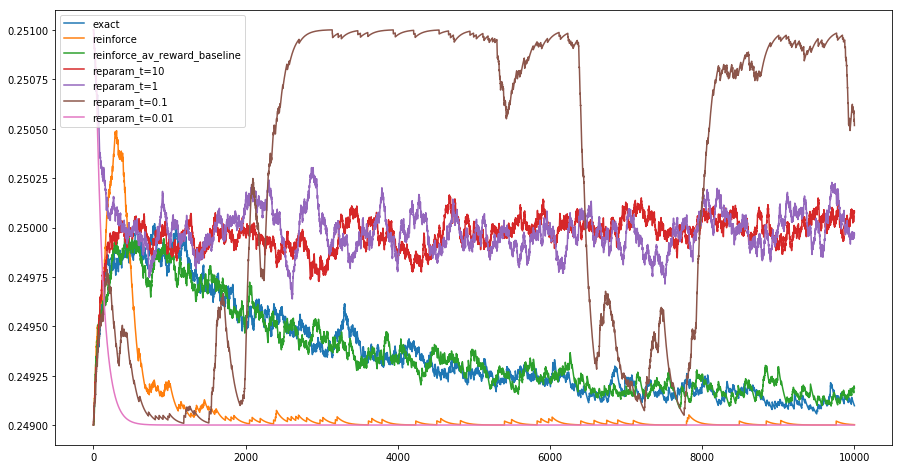

In [185]:
for mode in modes:
    plt.plot(exp_running_average(losses[mode], alpha=0.99))
plt.legend(modes)
#plt.ylim((0.2, 0.32))

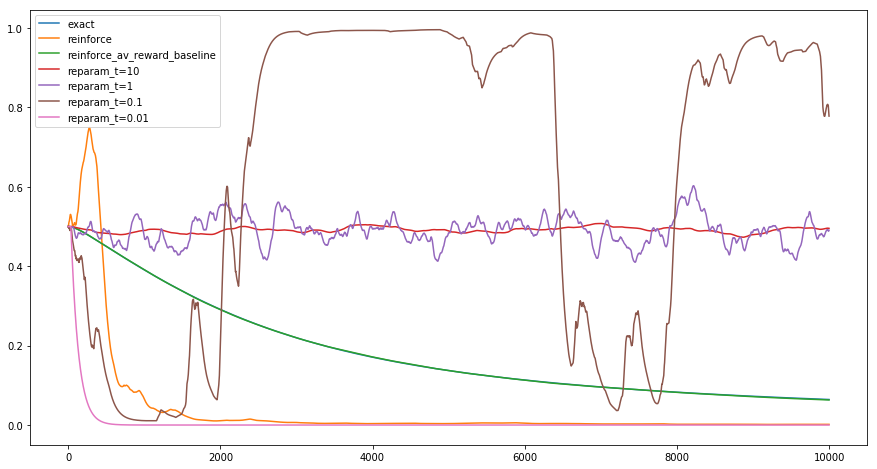

In [186]:
for mode in modes:
    plt.plot(exp_running_average(probs[mode], alpha=0.99))
plt.legend(modes)

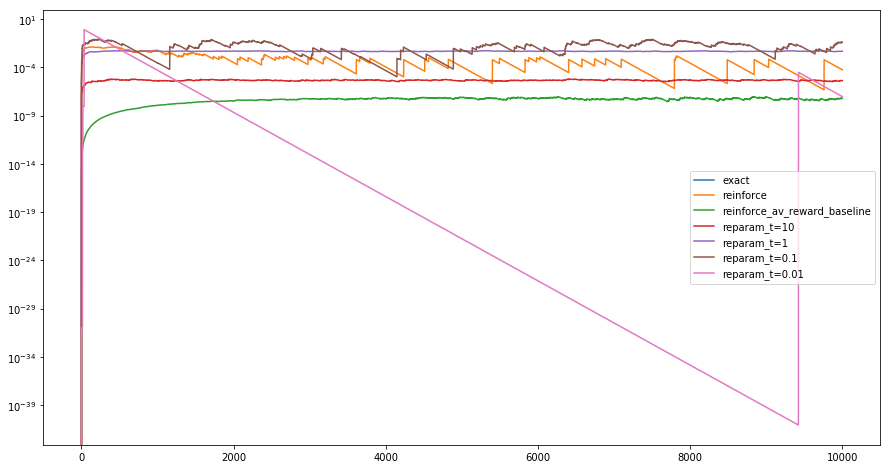

In [187]:
for mode in modes:
    plt.plot(grad_vars[mode])
plt.yscale('log')
plt.legend(modes)

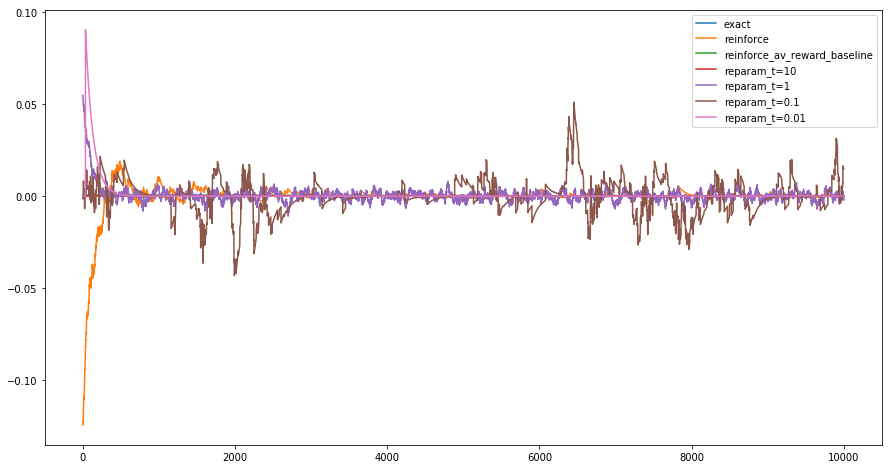

In [188]:
for mode in modes:
    plt.plot(exp_running_average(grad_estimates[mode], alpha=0.99))
#plt.yscale('log')
plt.legend(modes)

In [45]:
target ** 2, (1-target) ** 2

(0.249001, 0.251001)

In [156]:
'_'.join('')

''